# 3.6. Задача классификации вин с помощью нейронной сети.

*Если мы возьмём один и тот же код и запустим его несколько раз, то мы получим разные результаты.*

Это происходит потому, что каждый раз у нас инициализируются заново веса, происходит по-разному обучение нейронной сети, и это всё зависит от того, как отработал генератор случайных чисел в нашем процессоре. Возможно, мы хотим чтобы эксперименты были воспроизводимы: чтобы, взяв один и тот же питоновский файл и выполнив его, мы получили бы тот же самый результат, как и раньше. Например, это нужно для того чтобы понимать: а правда ли те изменения, которые мы делаем с нейросетью, улучшают наши результаты, или это результат некоторой случайности. Давайте зафиксируем вот эту случайность, которая из эксперимента в эксперимент нас преследует. Есть такое понятие как random seed, это можно интерпретировать, как номер последовательности случайных чисел, которую выдаст нам случайный генератор, если его попросить выдать нам последовательность.

In [14]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

**Задание 1.**

Фиксирование seed не гарантирует, что код будет одинаково выполняться на разных компьютерах. Но на одной и той же машине вы будете получать одинаковые результаты, перезапуская один и тот же скрипт.

Например, функция random.randint(start, end) отдает случайное целое число в диапазоне от start, end (включительно). Запуская скрипт, состоящий из вызова этой функции, вы будете получать разные ответы. 

В этом задании вам нужно подобрать seed, чтобы функция random.randint(0, 10) выдала число 5

PS: надо понимать, что фиксирование random seed не приведет к тому, что повторный вызов random.randint(0, 10) внутри того же скрипта снова даст 5. 

In [15]:
import random
random.seed(7)
random.randint(0, 10)

5

**Набор данных Wine dataset (sklearn).**

In [16]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [17]:
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Ma

**Обучение нейронной сети.**

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(wine.data[:, :2], wine.target, test_size=0.3, shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

**Задание 2.**

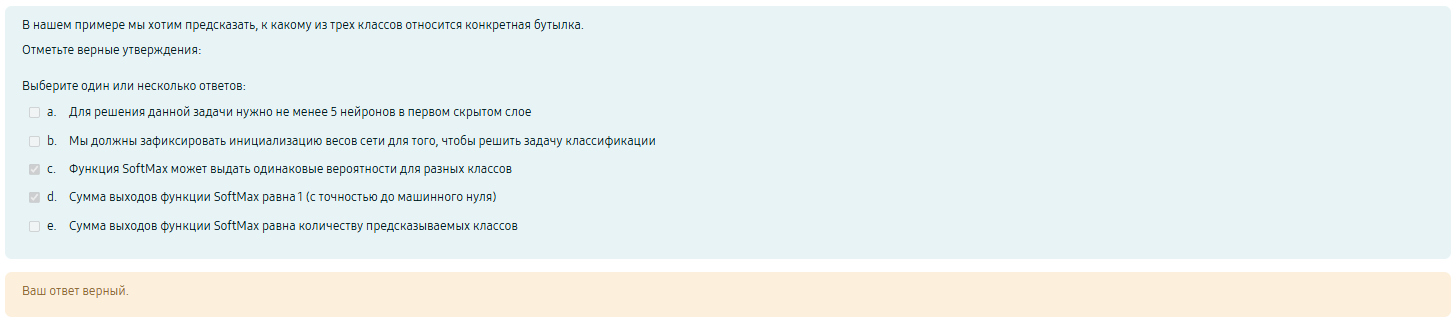

In [19]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
wine_net = WineNet(10)

**Задание 3.**

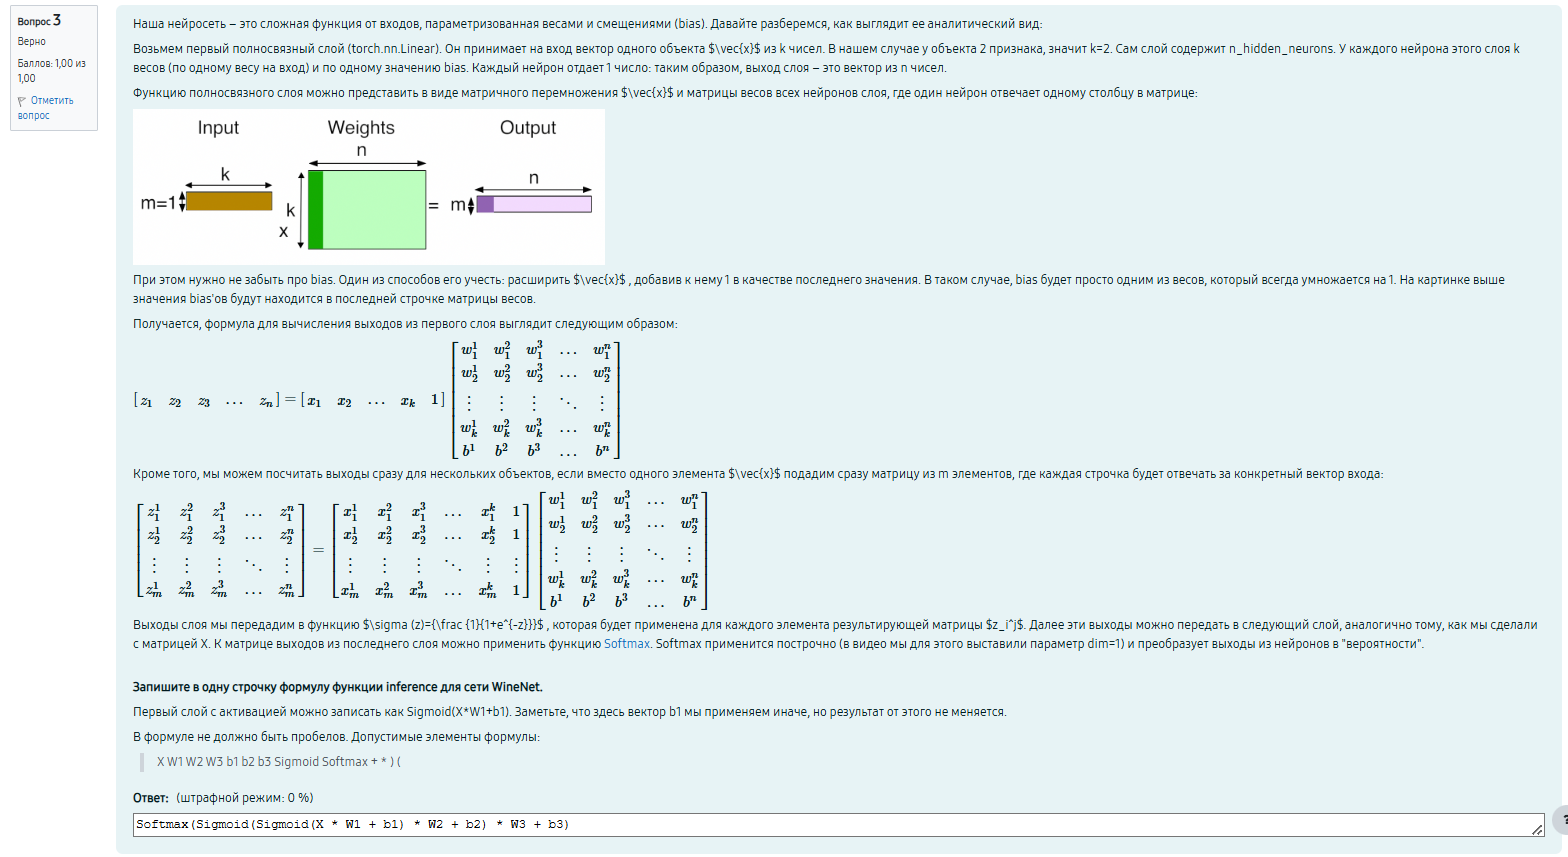

In [20]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(wine_net.parameters(), lr=1.0e-3)

**Задание 4.**

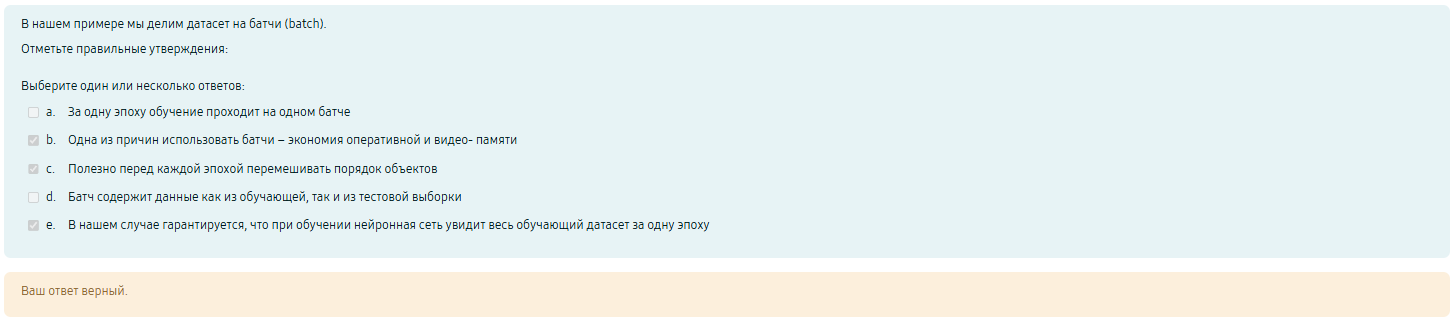

In [21]:
batch_size = 10

for epoch in range(5000):
    order = np.random.permutation(len(X_train)) # случайный набор чисел в указанном диапазоне
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)
        print((test_preds == y_test).float().mean())

tensor(0.3519)
tensor(0.5000)
tensor(0.5000)
tensor(0.5185)
tensor(0.7037)
tensor(0.8148)
tensor(0.8148)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8148)
tensor(0.8333)
tensor(0.8333)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8704)
tensor(0.8333)
tensor(0.8333)
tensor(0.8704)
tensor(0.8519)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.9259)
tensor(0.9259)
tensor(0.9074)
tensor(0.8704)
tensor(0.8704)
tensor(0.9074)
tensor(0.8889)
tensor(0.9074)
tensor(0.8889)
tensor(0.8519)
tensor(0.9259)
tensor(0.8519)
tensor(0.9074)
tensor(0.8519)
tensor(0.8889)
tensor(0.9074)
tensor(0.8704)
tensor(0.9074)
tensor(0.8889)


KeyboardInterrupt: 

C:\Users\Admin\AppData\Local\Temp\ipykernel_53888\2529696004.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train[indexes, 0],


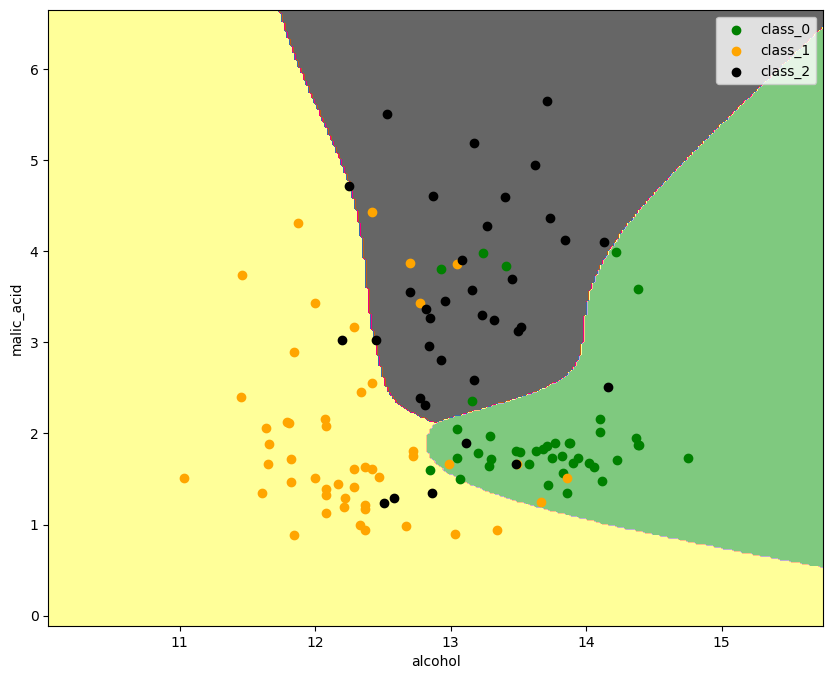

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()